In [1]:
import fsps
import dynesty
import sedpy
import h5py, astropy
import numpy as np
import astroquery
import prospect

In [2]:
sedpy.observate.list_available_filters()

['acs_wfc_f435w',
 'acs_wfc_f475w',
 'acs_wfc_f555w',
 'acs_wfc_f606w',
 'acs_wfc_f625w',
 'acs_wfc_f775w',
 'acs_wfc_f814w',
 'acs_wfc_f850lp',
 'bass_g',
 'bass_r',
 'bessell_B',
 'bessell_I',
 'bessell_R',
 'bessell_U',
 'bessell_V',
 'cfht_megacam_gs_9401',
 'cfht_megacam_is_9701',
 'cfht_megacam_rs_9601',
 'cfht_megacam_us_9301',
 'cfht_megacam_zs_9801',
 'cfht_wircam_H_8201',
 'cfht_wircam_J_8101',
 'cfht_wircam_Ks_8302',
 'decam_Y',
 'decam_g',
 'decam_i',
 'decam_r',
 'decam_u',
 'decam_z',
 'gaia_bp',
 'gaia_bp_dr2rev',
 'gaia_g',
 'gaia_g_dr2rev',
 'gaia_rp',
 'gaia_rp_dr2rev',
 'galex_FUV',
 'galex_NUV',
 'herschel_pacs_100',
 'herschel_pacs_160',
 'herschel_pacs_70',
 'herschel_spire_250',
 'herschel_spire_350',
 'herschel_spire_500',
 'hipparcos_B',
 'hipparcos_H',
 'hipparcos_V',
 'hsc_g',
 'hsc_i',
 'hsc_r',
 'hsc_y',
 'hsc_z',
 'jwst_f070w',
 'jwst_f090w',
 'jwst_f1000w',
 'jwst_f1130w',
 'jwst_f115w',
 'jwst_f1280w',
 'jwst_f140m',
 'jwst_f1500w',
 'jwst_f150w',
 'jwst

In [3]:
from astroquery.sdss import SDSS
from astropy.coordinates import SkyCoord
bands = "ugriz"
mcol = [f"cModelMag_{b}" for b in bands]
ecol = [f"cModelMagErr_{b}" for b in bands]
cat = SDSS.query_crossid(SkyCoord(ra=204.46376, dec=35.79883, unit="deg"),
                         data_release=16,
                         photoobj_fields=mcol + ecol + ["specObjID"])
shdus = SDSS.get_spectra(plate=2101, mjd=53858, fiberID=220)[0]
assert int(shdus[2].data["SpecObjID"][0]) == cat[0]["specObjID"]

In [4]:
from sedpy.observate import load_filters
from prospect.utils.obsutils import fix_obs

filters = load_filters([f"sdss_{b}0" for b in bands])
maggies = np.array([10**(-0.4 * cat[0][f"cModelMag_{b}"]) for b in bands])
magerr = np.array([cat[0][f"cModelMagErr_{b}"] for b in bands])
magerr = np.hypot(magerr, 0.05)

obs = dict(wavelength=None, spectrum=None, unc=None, redshift=shdus[2].data[0]["z"],
           maggies=maggies, maggies_unc=magerr * maggies / 1.086, filters=filters)
obs = fix_obs(obs)

In [5]:
obs

{'wavelength': None,
 'spectrum': None,
 'unc': None,
 'redshift': 0.07260209,
 'maggies': array([2.89648978e-08, 1.43326996e-07, 2.68124192e-07, 3.72848156e-07,
        4.41269591e-07]),
 'maggies_unc': array([1.43080360e-09, 6.62335988e-09, 1.23828212e-08, 1.72199203e-08,
        2.04937531e-08]),
 'filters': [<class 'sedpy.observate.Filter'>(sdss_u0),
  <class 'sedpy.observate.Filter'>(sdss_g0),
  <class 'sedpy.observate.Filter'>(sdss_r0),
  <class 'sedpy.observate.Filter'>(sdss_i0),
  <class 'sedpy.observate.Filter'>(sdss_z0)],
 'phot_mask': array([ True,  True,  True,  True,  True]),
 'filternames': ['sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'sdss_z0'],
 'logify_spectrum': False,
 'ndof': 5}

In [5]:
from prospect.models.templates import TemplateLibrary
from prospect.models import SpecModel
model_params = TemplateLibrary["parametric_sfh"]
model_params.update(TemplateLibrary["nebular"])
model_params["zred"]["init"] = obs["redshift"]

model = SpecModel(model_params)
assert len(model.free_params) == 5
print(model)


:::::::
<class 'prospect.models.sedmodel.SpecModel'>

Free Parameters: (name: prior) 
-----------
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1000000000000.0)
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.07260209] 
  sfh: [4] 
  imf_type: [2] 
  dust_type: [0] 
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemlineinspec: [ True] 
  gas_logz: [0.] <function stellar_logzsol at 0x13bf76a20>
  gas_logu: [-2.] 


In [6]:
noise_model = (None, None)

In [7]:
from prospect.sources import CSPSpecBasis
sps = CSPSpecBasis(zcontinuous=1)
print(sps.ssp.libraries)

(b'mist', b'miles', b'DL07')


In [8]:
current_parameters = ",".join([f"{p}={v}" for p, v in zip(model.free_params, model.theta)])
print(current_parameters)
spec, phot, mfrac = model.predict(model.theta, obs=obs, sps=sps)
print(phot / obs["maggies"])

mass=10000000000.0,logzsol=-0.5,dust2=0.6,tage=1.0,tau=1.0
[6.20590408 2.57369205 1.36383728 1.37353937 1.02406714]


In [9]:
from prospect.fitting import lnprobfn, fit_model
fitting_kwargs = dict(nlive_init=400, nested_method="rwalk", nested_target_n_effective=1000, nested_dlogz_init=0.05)
output = fit_model(obs, model, sps, optimize=False, dynesty=True, lnprobfn=lnprobfn, noise=noise_model, **fitting_kwargs)
result, duration = output["sampling"]

iter: 1413 | batch: 0 | nc: 1 | ncall: 18851 | eff(%):  7.496 | logz: 77.749 +/-  0.287 | dlogz:  0.000 >  0.050        


done dynesty (initial) in 419.46156191825867s


iter: 2227 | batch: 3 | nc: 1 | ncall: 28577 | eff(%):  6.815 | loglstar: 83.884 < 87.570 < 84.328 | logz: 77.802 +/-  0.249 | stop:  1.001      

done dynesty (dynamic) in 165.83015394210815s


In [10]:
from prospect.io import write_results as writer
hfile = "./quickstart_dynesty_mcmc.h5"
writer.write_hdf5(hfile, {}, model, obs,
                 output["sampling"][0], None,
                 sps=sps,
                 tsample=output["sampling"][1],
                 toptimize=0.0)

/Users/aswin/anaconda3/envs/obs/lib/python3.12/site-packages/prospect/io/write_results.py:60: RuntimeWarning: Could not store paramfile text
  warnings.warn("Could not store paramfile text", RuntimeWarning)
/Users/aswin/anaconda3/envs/obs/lib/python3.12/site-packages/prospect/io/write_results.py:301: RuntimeWarning: Could not JSON serialize model_params, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k),
/Users/aswin/anaconda3/envs/obs/lib/python3.12/site-packages/prospect/io/write_results.py:331: UserWarning: Could not JSON serialize redshift, pickled instead
  warnings.warn("Could not JSON serialize {}, pickled instead".format(k))
/Users/aswin/anaconda3/envs/obs/lib/python3.12/site-packages/prospect/io/write_results.py:49: RuntimeWarning: Could not obtain prospector version info
  warnings.warn("Could not obtain prospector version info", RuntimeWarning)


In [11]:
from prospect.io import read_results as reader
hfile = "./quickstart_dynesty_mcmc.h5"
out, out_obs, out_model = reader.results_from(hfile)

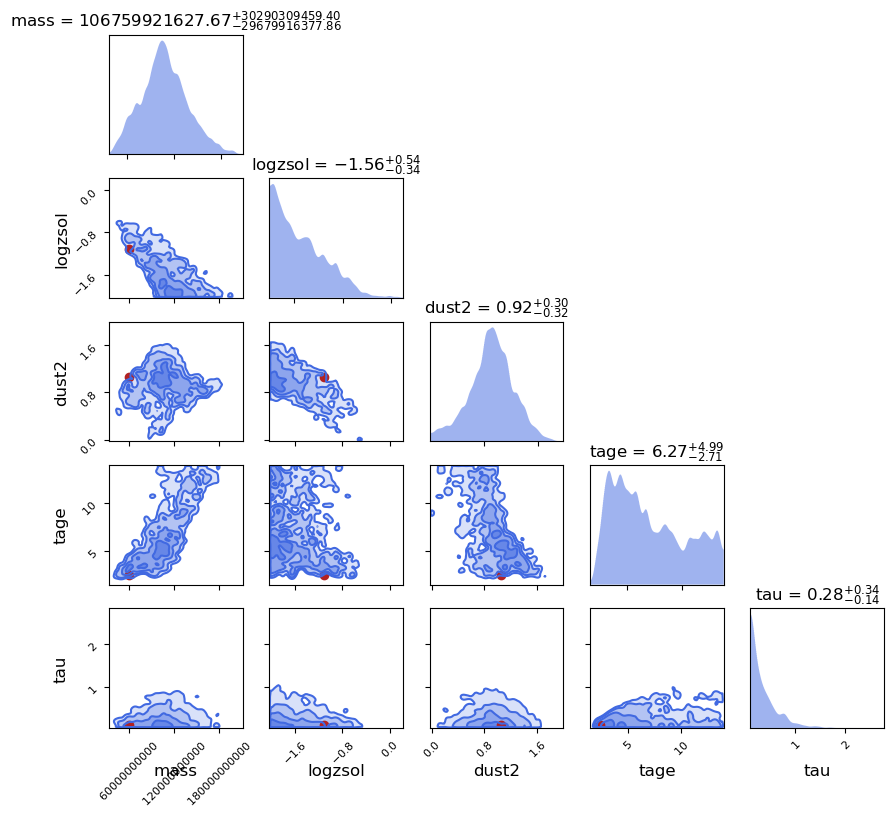

In [17]:
import matplotlib.pyplot as plt
from prospect.plotting import corner
nsamples, ndim = out["chain"].shape
cfig, axes = plt.subplots(ndim, ndim, figsize=(10,9))
axes = corner.allcorner(out["chain"].T, out["theta_labels"], axes, weights=out["weights"], color="royalblue", show_titles=True)

from prospect.plotting.utils import best_sample
pbest = best_sample(out)
corner.scatter(pbest[:, None], axes, color="firebrick", marker="o")

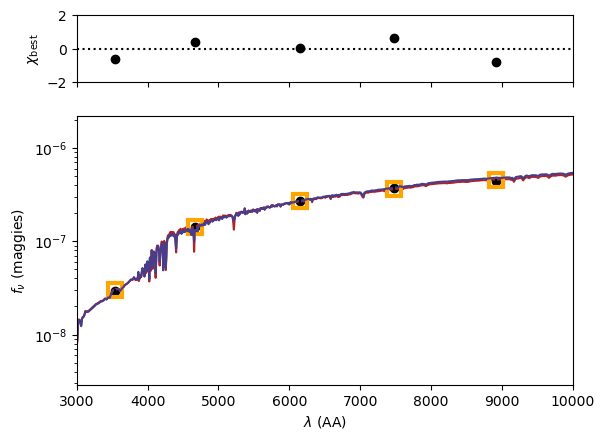

In [20]:
import matplotlib.pyplot as pl
sfig, saxes = pl.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k")
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(3e3, 1e4)
ax.set_ylim(out_obs["maggies"].min() * 0.1, out_obs["maggies"].max() * 5)
ax.set_yscale("log")

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-2, 2)
ax.set_ylabel(r"$\chi_{\rm best}$")

from prospect.plotting.utils import sample_posterior
# Here we fairly and randomly choose a posterior sample
p = sample_posterior(out["chain"], weights=out["weights"], nsample=1)
# show this sample in the corner plot
corner.scatter(p.T, axes, color="darkslateblue", marker="o")
# regenerate the spectrum and plot it
spec, phot, mfrac = model.predict(p[0], obs=out_obs, sps=sps)
ax = saxes[1]
ax.plot(sps.wavelengths * (1+out_obs["redshift"]), spec, color="darkslateblue", label="posterior sample")